## Guassian Discriminant Analysis

### Naive Bayes

In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd
import scipy.stats
from sklearn.model_selection import train_test_split 

In [63]:
import numpy as np

class Gaussian_NB():
    def __init__(self):
        pass
    
    def train(self, data):
        self.n_samples, self.n_features = data.shape[0], data.shape[1]-1
        self.classes = np.unique(data[:, -1])
        self.n_classes = len(self.classes)
        self._means = np.zeros((self.n_classes, self.n_features), dtype = np.float32)
        self._stds = np.zeros((self.n_classes, self.n_features), dtype = np.float32)
        data_c = np.zeros((self.n_samples, self.n_features-1), dtype = np.float32)
        
        for i, c in enumerate(self.classes):
            data_c = data[data[:,-1]==c]
            data_c = data_c[:, :-1]
            self._means[i, :] = data_c.mean(axis = 0)
            self._stds[i, :] = data_c.std(axis = 0)
        _, self.class_priors = np.unique(data[:, -1], return_counts = True)
        
    def predict(self, input_value):
        predictions = []
        for item in input_value:
            posteriors = np.zeros((self.n_classes, self.n_features))
            class_conditions = []
            for i in range(self.n_classes):
                for j in range(self.n_features):
                    posteriors[i][j] = scipy.stats.norm(loc = self._means[i][j], scale = self._stds[i][j]).pdf(item[j])
                class_conditions.append(np.log(posteriors[i, :]).sum() + np.log(self.class_priors[i]))
            predictions.append(np.argmax(class_conditions))
        return predictions

#### Load Iris Dataset

In [64]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['class'] = pd.Series(iris.target)

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Model, train and test

In [65]:
model = Gaussian_NB()

train, test = train_test_split(np.array(np.append(iris.data, iris.target[:, None], axis  = 1)), test_size = 0.2)
model.train(train)
print("model Accuracy: {0}".format(np.sum(model.predict(test[:, :-1]) == test[:, -1])/test.shape[0]))

model Accuracy: 1.0


In [222]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

class Multivariate_Guassian():
    
    def __init__(self, X, y, method = 'LDA'):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.classes = np.unique(y)
        self.method = method
        self.X_noramlized = []
        
        self.sigma = []
        
        #Overall mean
        self.overall_mean = X.mean(axis = 0)
        # COV matrix
        self.sigma.append(np.cov(X.T))
        self.priors = []
        self.means = np.zeros((len(self.classes), self.n_features))
        # mu matrix
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.priors.append(X_c.shape[0] / X.shape[0])
            self.means[i, :] = X_c.mean(axis = 0)
            self.sigma.append(np.cov(X_c.T))
            self.X_noramlized.append(X_c - self.means[i, :])    
    def LDA_score(self, input_x):
        probs = []
        for i, c in enumerate(self.classes):
            sigma_inv = np.linalg.inv(self.sigma[0])
            conditional_prob = np.log(self.priors[i]) - 0.5 * (self.means[i, :]).T @sigma_inv@ (self.means[i, :])\
            + input_x.T @sigma_inv@ (self.means[i, :])
            probs.append(conditional_prob)
        return probs
    
    def QDA_score(self, input_x):
        probs = []
        for i, c in enumerate(self.classes):
            sigma_inv = np.linalg.inv(self.sigma[i+1])
            conditional_prob = (np.log(self.priors[i]) - 0.5 * np.log(np.linalg.det(sigma_inv)) - 0.5 * (input_x - self.means[i, :]).T @sigma_inv@ (input_x - self.means[i, :])).flatten()[0]
            probs.append(conditional_prob)
        return probs
    
    def predict(self, x):
        predictions = []
        costs = []
        for input_value in x:
            if self.method == 'LDA':
                probs = self.LDA_score(input_value)
            else:
                probs = self.QDA_score(input_value)
            predict = np.argmax(probs)
            cost = sum(probs) - probs[predict]
            predictions.append(predict)
            costs.append(cost)
        return np.array(cost), np.array(predictions)
    
    def LDA_boundary(self):
        boundaries = []
        #For each pair of classes, a boundary is defined
        sigma_inv = np.linalg.inv(self.sigma[0])
        boundaries = [(np.log(self.priors[i] / self.priors[j]) - 0.5 * (self.means[i, :] + self.means[j, :]).T @sigma_inv@(self.means[i, :] - self.means[j, :]),
                      (sigma_inv@(self.means[i, :] - self.means[j, :]))) for i, j in itertools.combinations(range(len(self.classes)), 2)]
        return boundaries
    
#     def QDA_boundary(self):
#         boundaries = []
    def linear_transformation(self, n_components):
        S_W = np.zeros((self.n_features, self.n_features))
        S_B = np.zeros((self.n_features, self.n_features))
        for i, m in enumerate(self.X_noramlized):
            S_W += m.T@m
            mean_diff = self.means[i, :] - self.overall_mean
            S_B += (m.shape[0] * (mean_diff.T@mean_diff))
        A = np.linalg.inv(S_W)@S_B
        eig_values, eig_vectors = np.linalg.eig(A)
        eig_vectors = eig_vectors.T
        indices = np.argsort(abs(eig_values))[::-1]
        eig_values = eig_values[indices]
        eig_vectors = eig_vectors[indices]
        return(eig_vectors[0:n_components])

In [223]:
lda = Multivariate_Guassian(train[:, :-1], train[:, -1])
qda = Multivariate_Guassian(train[:, :-1], train[:, -1], method = 'QDA')

lda_costs, lda_predictions = np.array(lda.predict(test[:, :-1]))
qda_costs, qda_predictions = np.array(lda.predict(test[:, :-1]))

print("LDA Accuracy = {0} \nQDA Accuracy = {1}".format(np.sum((lda_predictions == test[:, -1])) /test.shape[0],
                                                      np.sum(np.array(qda_predictions) == test[:, -1]) /test.shape[0]))

print("LDA average Loss = {0:.4f}\nQDA average Los = {1:.4f}".format(np.sum(lda_costs)/test.shape[0], np.sum(qda_costs)
                                                           /test.shape[0]))

LDA Accuracy = 0.9 
QDA Accuracy = 0.9
LDA average Loss = 3.6660
QDA average Los = 3.6660


In [171]:
lda_predictions = np.array(lda_predictions)
test[:, -1] == lda_predictions.reshape(-1, 1)
lda_predictions.reshape(-1, 1).shape
lda_predictions.shape

AttributeError: 'numpy.ndarray' object has no attribute '_reshape'

In [199]:
x = np.array([[1, 2, 3],
             [4, 5, 6]])
x.dot(x.T)

array([[14, 32],
       [32, 77]])

### Linear Transformations

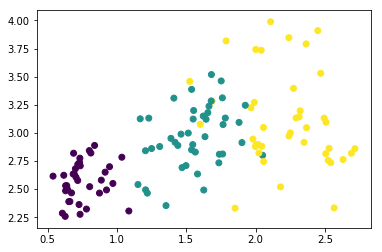

In [232]:
visualize(train[:, :-1]@lda.linear_transformation(2).T, train[:, -1])

In [235]:
def visualize(x, y):
    plt.scatter(x[:, 0], x[:, 1], c = y, cmap = plt.cm.get_cmap('viridis', 3))
    plt.colorbar()
    plt.show()

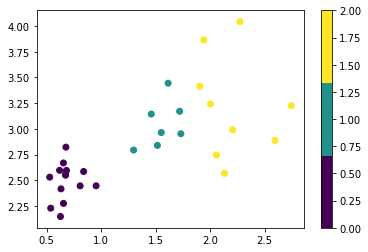

In [236]:
visualize(test[:, :-1]@lda.linear_transformation(2).T, test[:, -1])